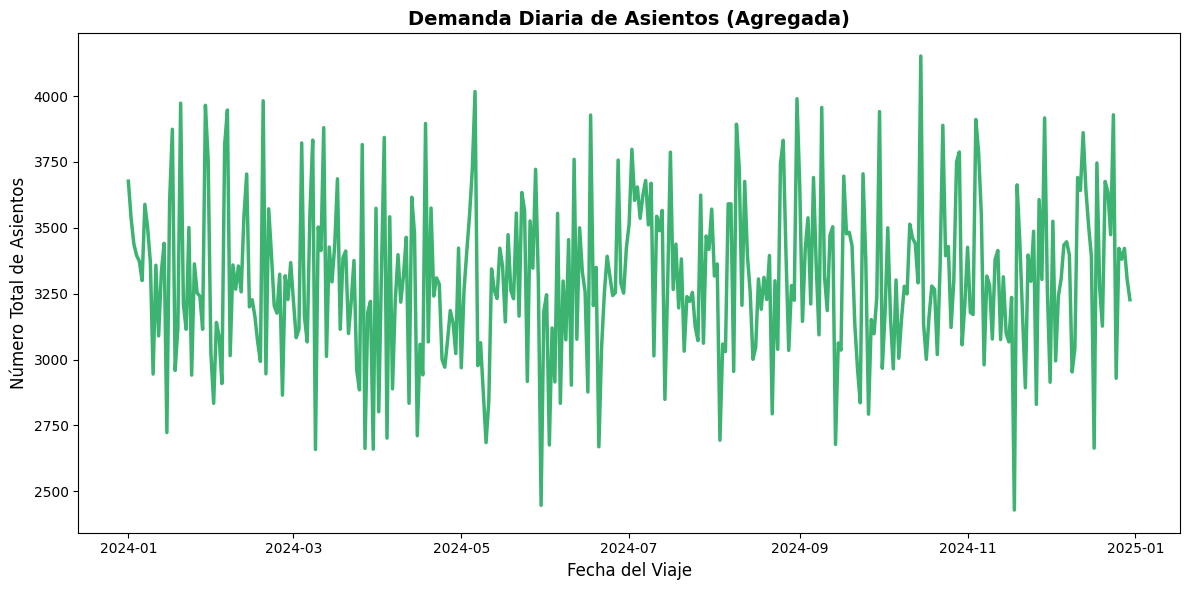


Primeras 5 filas de la serie de tiempo agregada:
travel_date
2024-01-01    3677
2024-01-02    3536
2024-01-03    3439
2024-01-04    3395
2024-01-05    3373
Name: seat_number, dtype: int64


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# --- 1. Generación de Datos (tu código original) ---
# Set random seed for reproducibility
np.random.seed(2)

# Parameters
n_samples = 50000  # Number of rides
locations = ['Punto_1', 'Punto_2', 'Punto_3', 'Punto_4', 'Punto_5']
car_types = ['Autobus', 'microbus', 'van','Tranvía']
payment_methods = ['Tarjeta', 'Efectivo', 'App_móvil', 'Transferencia']
start_date = datetime(2024, 1, 1)

# Generate data
ride_ids = np.arange(1, n_samples + 1)
travel_dates = [start_date + timedelta(days=np.random.randint(0, 365)) for _ in range(n_samples)]
travel_times = [datetime(2024, 1, 1, np.random.randint(0, 24), np.random.randint(0, 60)).time() for _ in range(n_samples)]
travel_from = np.random.choice(locations, n_samples)
travel_to = np.random.choice(locations, n_samples)
car_type = np.random.choice(car_types, n_samples)
max_capacity = np.random.choice([14, 30, 50], n_samples)
payment_method = np.random.choice(payment_methods, n_samples)

# Calculate seat_number based on some logic
seat_number = (np.random.poisson(lam=10, size=n_samples)
               + (max_capacity / 2).astype(int)
               + np.random.randint(0, 5, n_samples)
               - (np.array([t.hour for t in travel_times]) // 3)
               + (payment_method == 'Transferencia').astype(int) * 5
              ).clip(1, max_capacity)

# Create the DataFrame
data = pd.DataFrame({
    'ride_id': ride_ids,
    'travel_date': travel_dates,
    'travel_time': travel_times,
    'travel_from': travel_from,
    'travel_to': travel_to,
    'car_type': car_type,
    'max_capacity': max_capacity,
    'payment_method': payment_method,
    'seat_number': seat_number
})


# --- 2. Preparación de Datos para ARIMA (mi sugerencia) ---

# Asegurarnos que 'travel_date' es de tipo datetime
data['travel_date'] = pd.to_datetime(data['travel_date'])

# Agrupamos por fecha y sumamos el número de asientos para obtener la demanda diaria
time_series_data = data.groupby('travel_date')['seat_number'].sum()

# Ordenamos la serie por fecha (importante para ARIMA)
time_series_data = time_series_data.sort_index()

# Visualizamos la nueva serie temporal agregada
plt.figure(figsize=(12, 6))
sns.lineplot(data=time_series_data, color='mediumseagreen', linewidth=2.5)
plt.title('Demanda Diaria de Asientos (Agregada)', fontsize=14, fontweight='bold')
plt.xlabel('Fecha del Viaje', fontsize=12)
plt.ylabel('Número Total de Asientos', fontsize=12)
plt.tight_layout()
plt.show()

# Imprimimos las primeras filas de nuestra nueva serie
print("\nPrimeras 5 filas de la serie de tiempo agregada:")
print(time_series_data.head())

Resultados de la Prueba de Dickey-Fuller Aumentada:
Test Statistic                 -19.891018
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


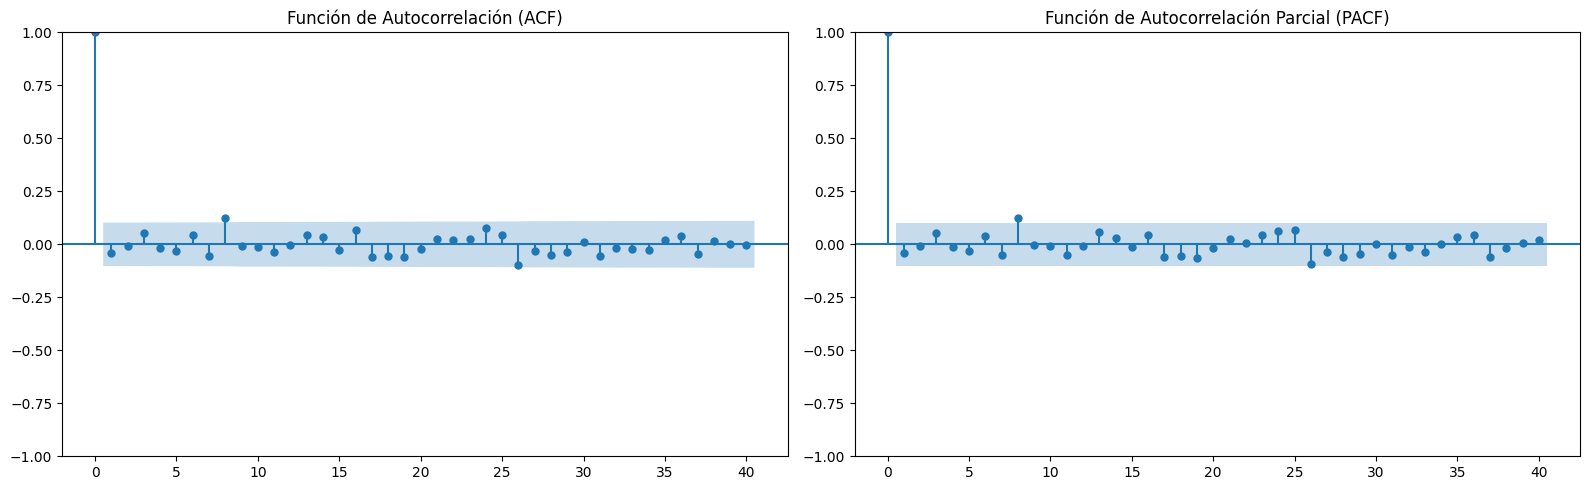

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# --- Prueba de Dickey-Fuller Aumentada (ADF) ---
print('Resultados de la Prueba de Dickey-Fuller Aumentada:')
adf_test = adfuller(time_series_data, autolag='AIC')
adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_test[4].items():
    adf_output[f'Critical Value ({key})'] = value

print(adf_output)

# --- Gráficos de Autocorrelación ---
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico ACF
plot_acf(time_series_data, ax=axes[0], lags=40, title='Función de Autocorrelación (ACF)')

# Gráfico PACF
plot_pacf(time_series_data, ax=axes[1], lags=40, title='Función de Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

In [3]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore") # Ignorar advertencias de convergencia

# --- Ajustar los modelos candidatos ---

# Modelo ARIMA(1,0,0) - AR(1)
model_ar = ARIMA(time_series_data, order=(1, 0, 0))
results_ar = model_ar.fit()
print("--- Resumen del Modelo ARIMA(1,0,0) ---")
print(results_ar.summary())
print("\\n" + "="*50 + "\\n")


# Modelo ARIMA(0,0,1) - MA(1)
model_ma = ARIMA(time_series_data, order=(0, 0, 1))
results_ma = model_ma.fit()
print("--- Resumen del Modelo ARIMA(0,0,1) ---")
print(results_ma.summary())
print("\\n" + "="*50 + "\\n")


# Modelo ARIMA(1,0,1) - ARMA(1,1)
model_arma = ARIMA(time_series_data, order=(1, 0, 1))
results_arma = model_arma.fit()
print("--- Resumen del Modelo ARIMA(1,0,1) ---")
print(results_arma.summary())

--- Resumen del Modelo ARIMA(1,0,0) ---
                               SARIMAX Results                                
Dep. Variable:            seat_number   No. Observations:                  365
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2605.089
Date:                Thu, 03 Jul 2025   AIC                           5216.179
Time:                        16:29:17   BIC                           5227.878
Sample:                    01-01-2024   HQIC                          5220.828
                         - 12-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3307.7753     15.343    215.595      0.000    3277.705    3337.846
ar.L1         -0.0425      0.052     -0.818      0.413      -0.144       0.059
sigma2      

In [4]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# --- Ajustar los modelos y mostrar solo el AIC ---

print("--- Comparación de AIC de los Modelos ---")

# Modelo ARIMA(1,0,0)
model_ar = ARIMA(time_series_data, order=(1, 0, 0))
results_ar = model_ar.fit()
print(f"AIC para ARIMA(1,0,0): {results_ar.aic}")

# Modelo ARIMA(0,0,1)
model_ma = ARIMA(time_series_data, order=(0, 0, 1))
results_ma = model_ma.fit()
print(f"AIC para ARIMA(0,0,1): {results_ma.aic}")

# Modelo ARIMA(1,0,1)
model_arma = ARIMA(time_series_data, order=(1, 0, 1))
results_arma = model_arma.fit()
print(f"AIC para ARIMA(1,0,1): {results_arma.aic}")

--- Comparación de AIC de los Modelos ---
AIC para ARIMA(1,0,0): 5216.178543137101
AIC para ARIMA(0,0,1): 5216.175789099528
AIC para ARIMA(1,0,1): 5218.175557586861


--- Gráficas de Diagnóstico para el Modelo ARIMA(0,0,1) ---


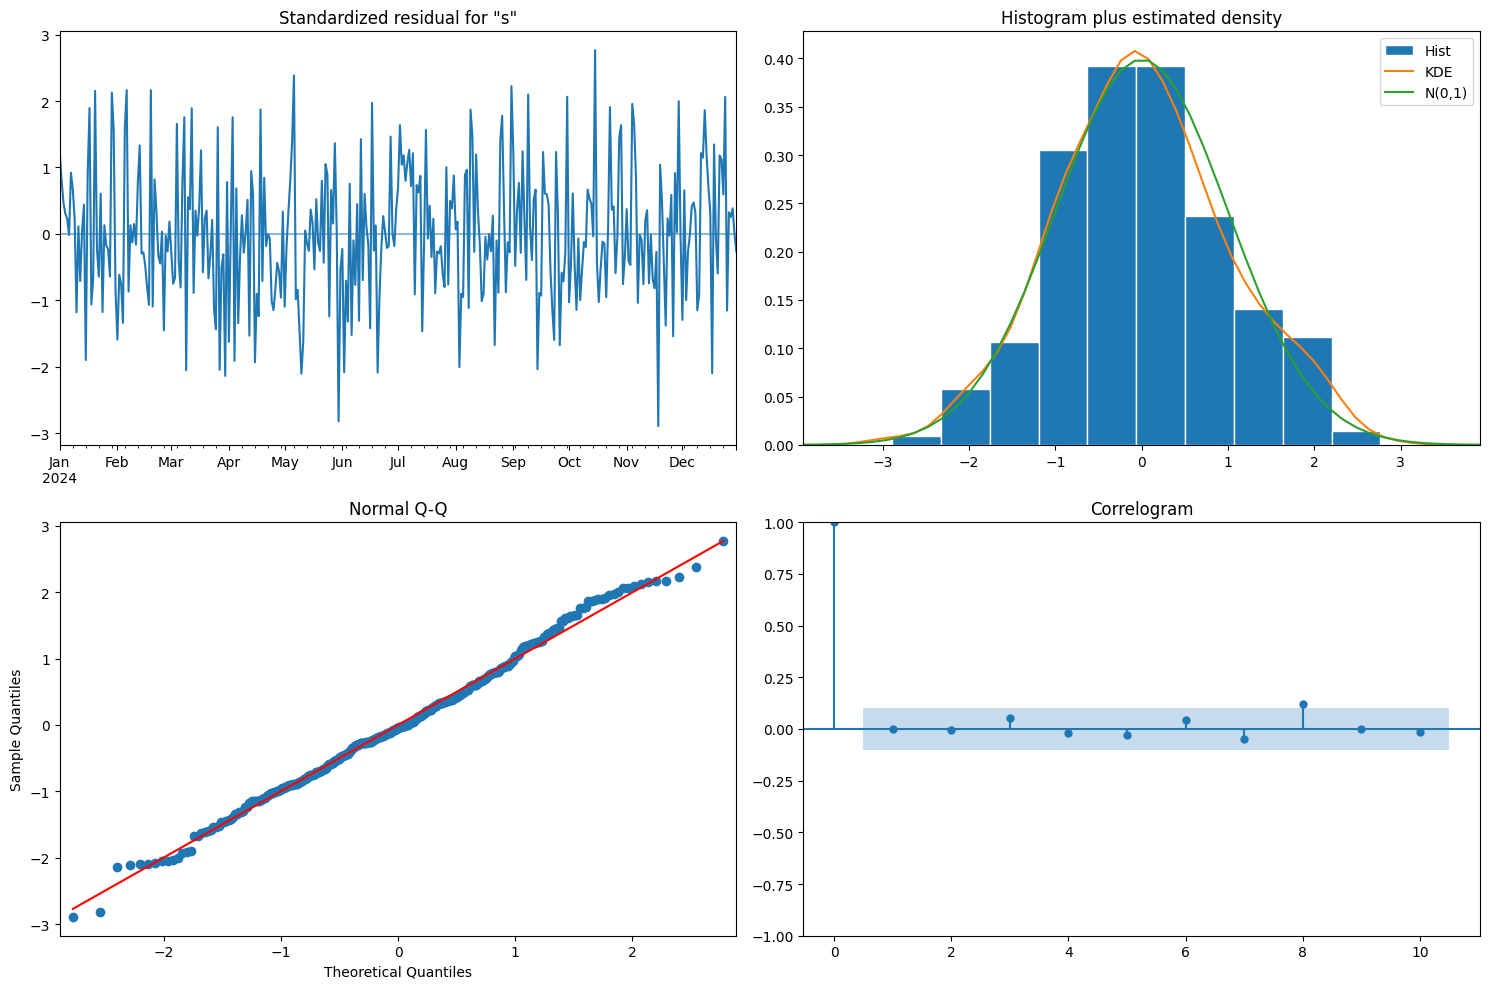

In [5]:
import matplotlib.pyplot as plt

# Usamos los resultados del modelo ARIMA(0,0,1) que guardamos en la variable 'results_ma'
# y generamos las gráficas de diagnóstico.
print("--- Gráficas de Diagnóstico para el Modelo ARIMA(0,0,1) ---")
results_ma.plot_diagnostics(figsize=(15, 10))
plt.tight_layout()
plt.show()

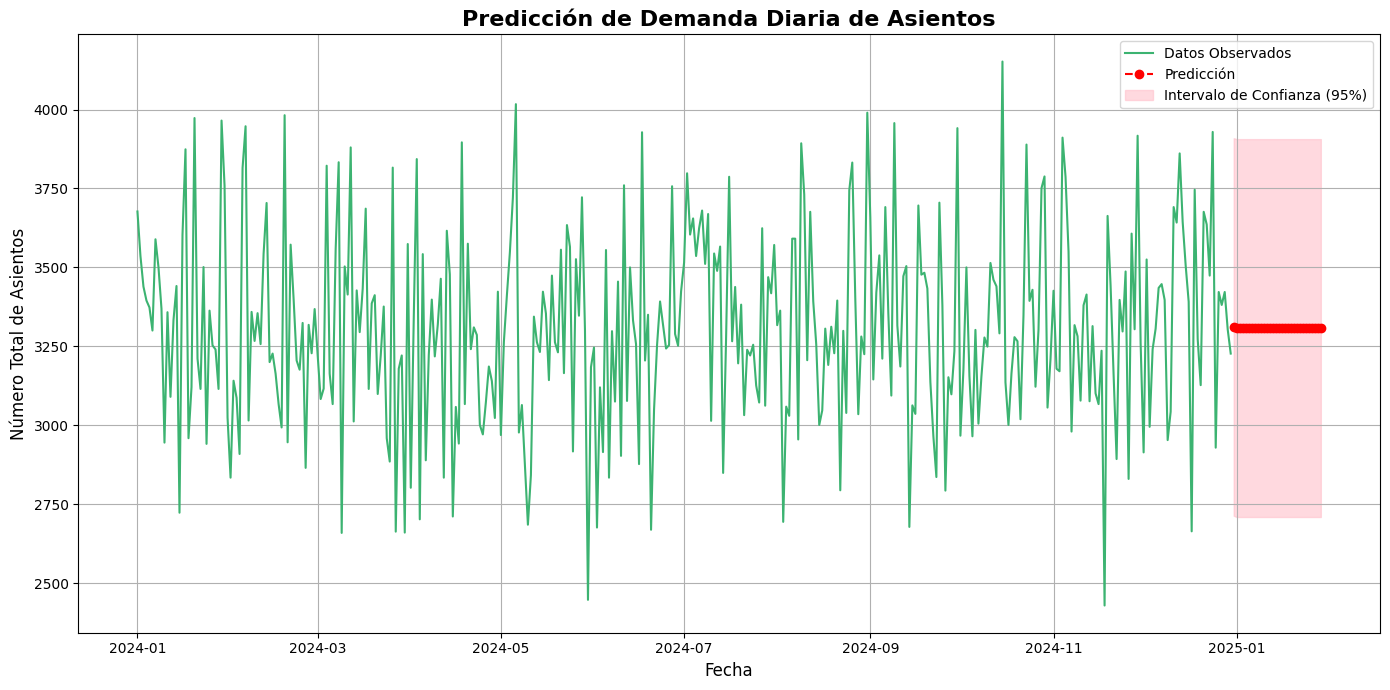

\n--- Valores Predichos para los Próximos 30 Días ---
2024-12-31    3311.241214
2025-01-01    3307.775306
2025-01-02    3307.775306
2025-01-03    3307.775306
2025-01-04    3307.775306
2025-01-05    3307.775306
2025-01-06    3307.775306
2025-01-07    3307.775306
2025-01-08    3307.775306
2025-01-09    3307.775306
2025-01-10    3307.775306
2025-01-11    3307.775306
2025-01-12    3307.775306
2025-01-13    3307.775306
2025-01-14    3307.775306
2025-01-15    3307.775306
2025-01-16    3307.775306
2025-01-17    3307.775306
2025-01-18    3307.775306
2025-01-19    3307.775306
2025-01-20    3307.775306
2025-01-21    3307.775306
2025-01-22    3307.775306
2025-01-23    3307.775306
2025-01-24    3307.775306
2025-01-25    3307.775306
2025-01-26    3307.775306
2025-01-27    3307.775306
2025-01-28    3307.775306
2025-01-29    3307.775306
Freq: D, Name: predicted_mean, dtype: float64


In [6]:
import matplotlib.pyplot as plt

# --- Realizar la predicción ---
# Definimos cuántos días hacia el futuro queremos predecir
dias_a_predecir = 30

# Usamos el método get_forecast sobre los resultados del modelo ARIMA(0,0,1)
forecast = results_ma.get_forecast(steps=dias_a_predecir)

# Extraemos los valores predichos
mean_forecast = forecast.predicted_mean

# Extraemos los intervalos de confianza
confidence_intervals = forecast.conf_int()


# --- Visualizar la predicción ---
plt.figure(figsize=(14, 7))

# Graficar los datos originales
plt.plot(time_series_data, label='Datos Observados', color='mediumseagreen')

# Graficar la predicción
plt.plot(mean_forecast.index, mean_forecast.values, color='red', marker='o', linestyle='--', label='Predicción')

# Sombrear el intervalo de confianza
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.6, label='Intervalo de Confianza (95%)')

plt.title('Predicción de Demanda Diaria de Asientos', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número Total de Asientos', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Imprimir los valores predichos para los próximos días
print("\\n--- Valores Predichos para los Próximos 30 Días ---")
print(mean_forecast)

In [9]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Ignorar advertencias para mantener la salida limpia
warnings.filterwarnings("ignore")

# Rango de valores para p y q
p_values = range(0, 4)
q_values = range(0, 4)
d_value = 0 # Ya sabemos que es 0

# Lista para guardar los resultados
results_list = []

print("--- Iniciando búsqueda del mejor modelo ARIMA ---")

# Bucle para probar todas las combinaciones
for p in p_values:
    for q in q_values:
        order = (p, d_value, q)
        try:
            # Crear y ajustar el modelo
            model = ARIMA(time_series_data, order=order)
            results = model.fit()
            
            # Guardar el orden y el AIC
            results_list.append((order, results.aic))
            print(f"Probando ARIMA{order}... AIC = {results.aic}")
            
        except Exception as e:
            # Algunas combinaciones pueden fallar, las ignoramos
            print(f"ARIMA{order} falló: {e}")
            continue

# Convertir la lista de resultados a un DataFrame para fácil visualización
results_df = pd.DataFrame(results_list, columns=['Order', 'AIC'])

# Ordenar los resultados por el AIC más bajo
best_models = results_df.sort_values(by='AIC').reset_index(drop=True)

print("\\n" + "="*50 + "\\n")
print("--- Los 5 Mejores Modelos Encontrados ---")
print(best_models.head())

--- Iniciando búsqueda del mejor modelo ARIMA ---
Probando ARIMA(0, 0, 0)... AIC = 5214.838804129708
Probando ARIMA(0, 0, 1)... AIC = 5216.175789099528
Probando ARIMA(0, 0, 2)... AIC = 5218.19690354843
Probando ARIMA(0, 0, 3)... AIC = 5219.304320266288
Probando ARIMA(1, 0, 0)... AIC = 5216.178543137101
Probando ARIMA(1, 0, 1)... AIC = 5218.175557586861
Probando ARIMA(1, 0, 2)... AIC = 5220.055337925269
Probando ARIMA(1, 0, 3)... AIC = 5221.0838845667795
Probando ARIMA(2, 0, 0)... AIC = 5218.157078474835
Probando ARIMA(2, 0, 1)... AIC = 5219.946627126448
Probando ARIMA(2, 0, 2)... AIC = 5220.924436986089
Probando ARIMA(2, 0, 3)... AIC = 5218.276342482859
Probando ARIMA(3, 0, 0)... AIC = 5219.118890559072
Probando ARIMA(3, 0, 1)... AIC = 5221.088774624848
Probando ARIMA(3, 0, 2)... AIC = 5223.36593174036
Probando ARIMA(3, 0, 3)... AIC = 5222.13663905407
\n==================================================\n
--- Los 5 Mejores Modelos Encontrados ---
       Order          AIC
0  (0, 0, 0) 

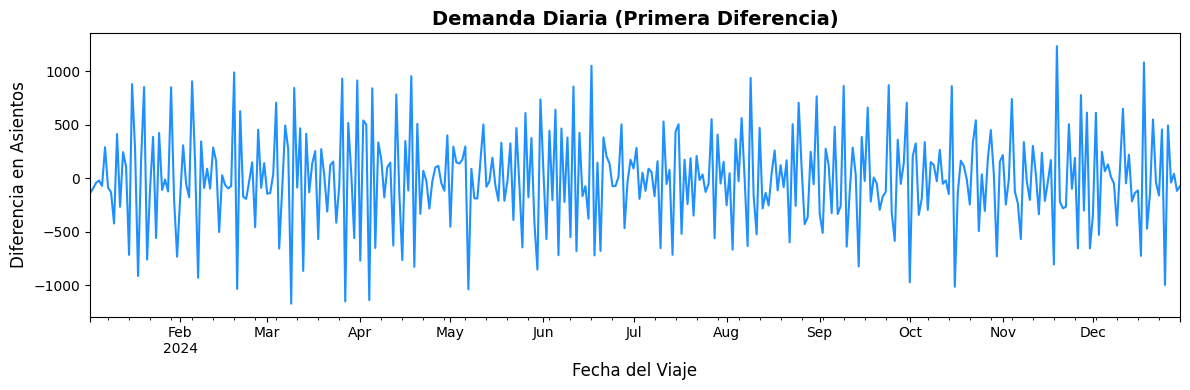

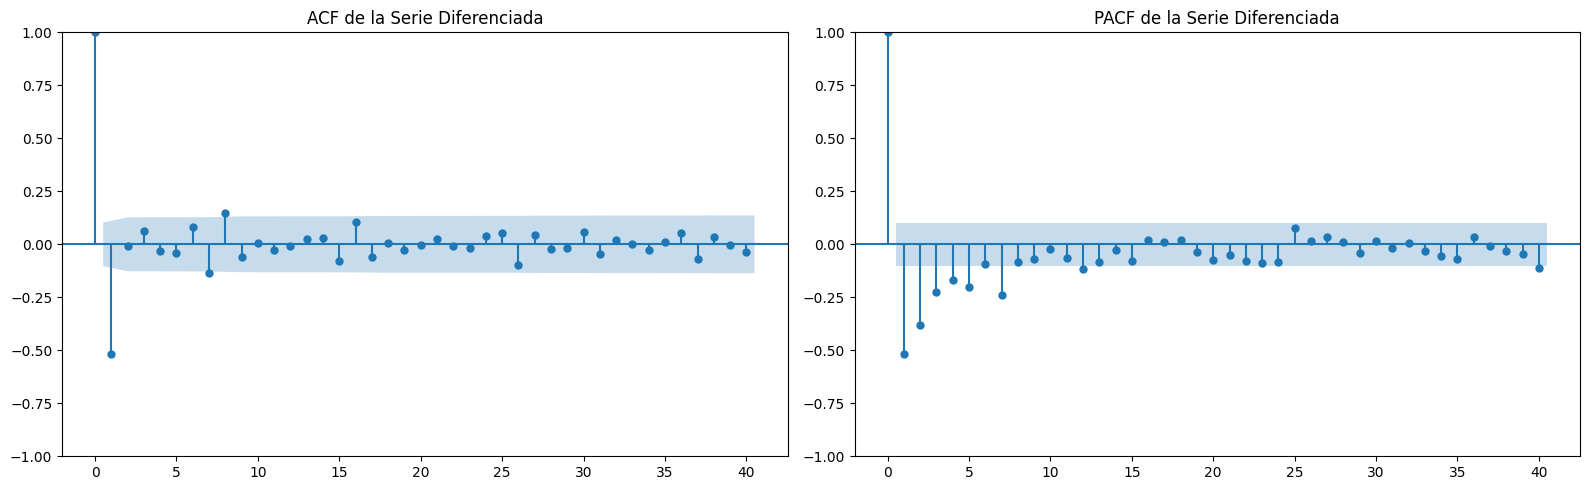

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# --- 1. Calcular la primera diferencia de la serie ---
# Esto es simplemente restar a cada día el valor del día anterior
time_series_diff = time_series_data.diff().dropna()


# --- 2. Visualizar la serie diferenciada ---
plt.figure(figsize=(12, 4))
time_series_diff.plot(color='dodgerblue')
plt.title('Demanda Diaria (Primera Diferencia)', fontsize=14, fontweight='bold')
plt.xlabel('Fecha del Viaje', fontsize=12)
plt.ylabel('Diferencia en Asientos', fontsize=12)
plt.tight_layout()
plt.show()


# --- 3. Graficar ACF y PACF de la serie diferenciada ---
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico ACF
plot_acf(time_series_diff, ax=axes[0], lags=40, title='ACF de la Serie Diferenciada')

# Gráfico PACF
plot_pacf(time_series_diff, ax=axes[1], lags=40, title='PACF de la Serie Diferenciada')

plt.tight_layout()
plt.show()

In [12]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

print("--- Comparación Final de Modelos ARIMA (con d=1) ---")

# Modelo ARIMA(1,1,0)
try:
    model_110 = ARIMA(time_series_data, order=(1, 1, 0))
    results_110 = model_110.fit()
    print(f"AIC para ARIMA(1,1,0): {results_110.aic}")
except Exception as e:
    print("ARIMA(1,1,0) falló.")

# Modelo ARIMA(0,1,1)
try:
    model_011 = ARIMA(time_series_data, order=(0, 1, 1))
    results_011 = model_011.fit()
    print(f"AIC para ARIMA(0,1,1): {results_011.aic}")
except Exception as e:
    print("ARIMA(0,1,1) falló.")

--- Comparación Final de Modelos ARIMA (con d=1) ---
AIC para ARIMA(1,1,0): 5354.88667372181
AIC para ARIMA(0,1,1): 5205.975741298966


--- Gráficas de Diagnóstico para el Modelo Final ARIMA(0,1,1) ---


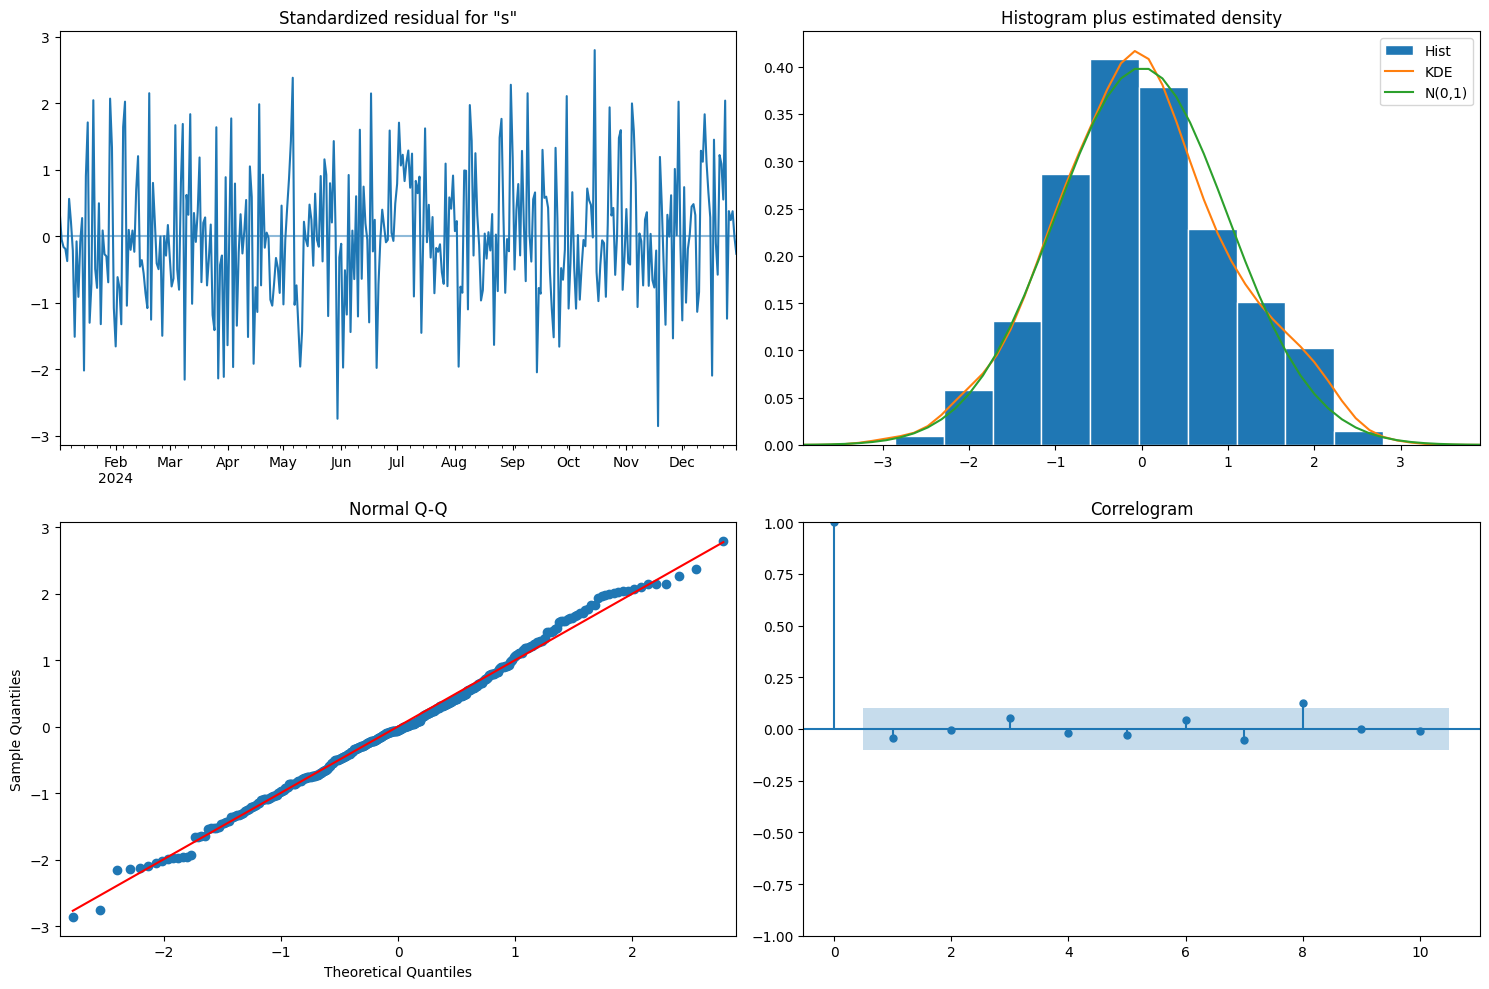

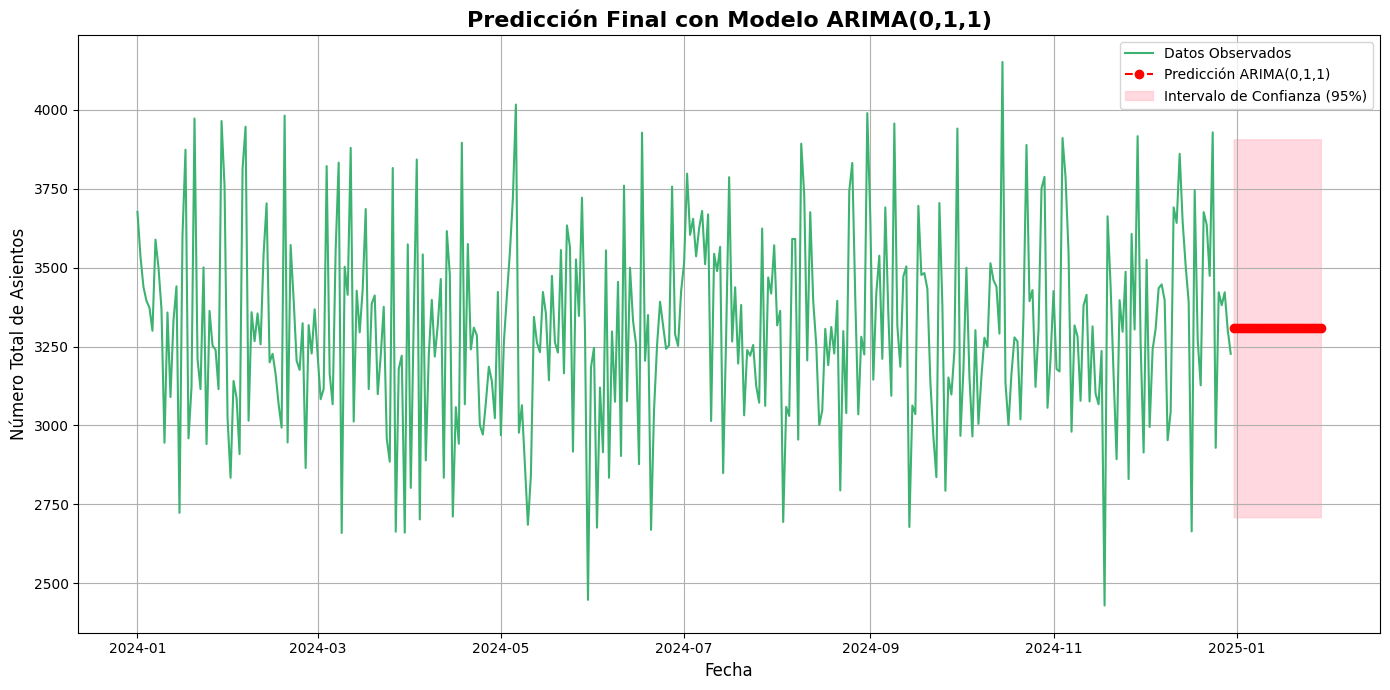


--- Predicción Final ---
2024-12-31    3308.11154
2025-01-01    3308.11154
2025-01-02    3308.11154
2025-01-03    3308.11154
2025-01-04    3308.11154
2025-01-05    3308.11154
2025-01-06    3308.11154
2025-01-07    3308.11154
2025-01-08    3308.11154
2025-01-09    3308.11154
2025-01-10    3308.11154
2025-01-11    3308.11154
2025-01-12    3308.11154
2025-01-13    3308.11154
2025-01-14    3308.11154
2025-01-15    3308.11154
2025-01-16    3308.11154
2025-01-17    3308.11154
2025-01-18    3308.11154
2025-01-19    3308.11154
2025-01-20    3308.11154
2025-01-21    3308.11154
2025-01-22    3308.11154
2025-01-23    3308.11154
2025-01-24    3308.11154
2025-01-25    3308.11154
2025-01-26    3308.11154
2025-01-27    3308.11154
2025-01-28    3308.11154
2025-01-29    3308.11154
Freq: D, Name: predicted_mean, dtype: float64


In [13]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# --- 1. Ajustar el modelo ganador definitivo ---
final_model = ARIMA(time_series_data, order=(0, 1, 1))
final_results = final_model.fit()

# --- 2. Mostrar las gráficas de diagnóstico ---
print("--- Gráficas de Diagnóstico para el Modelo Final ARIMA(0,1,1) ---")
final_results.plot_diagnostics(figsize=(15, 10))
plt.tight_layout()
plt.show()

# --- 3. Realizar y visualizar la predicción final ---
dias_a_predecir = 30
forecast = final_results.get_forecast(steps=dias_a_predecir)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

plt.figure(figsize=(14, 7))
plt.plot(time_series_data, label='Datos Observados', color='mediumseagreen')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', marker='o', linestyle='--', label='Predicción ARIMA(0,1,1)')
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.6, label='Intervalo de Confianza (95%)')

plt.title('Predicción Final con Modelo ARIMA(0,1,1)', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número Total de Asientos', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Imprimir los valores predichos
print("\n--- Predicción Final ---")
print(mean_forecast)

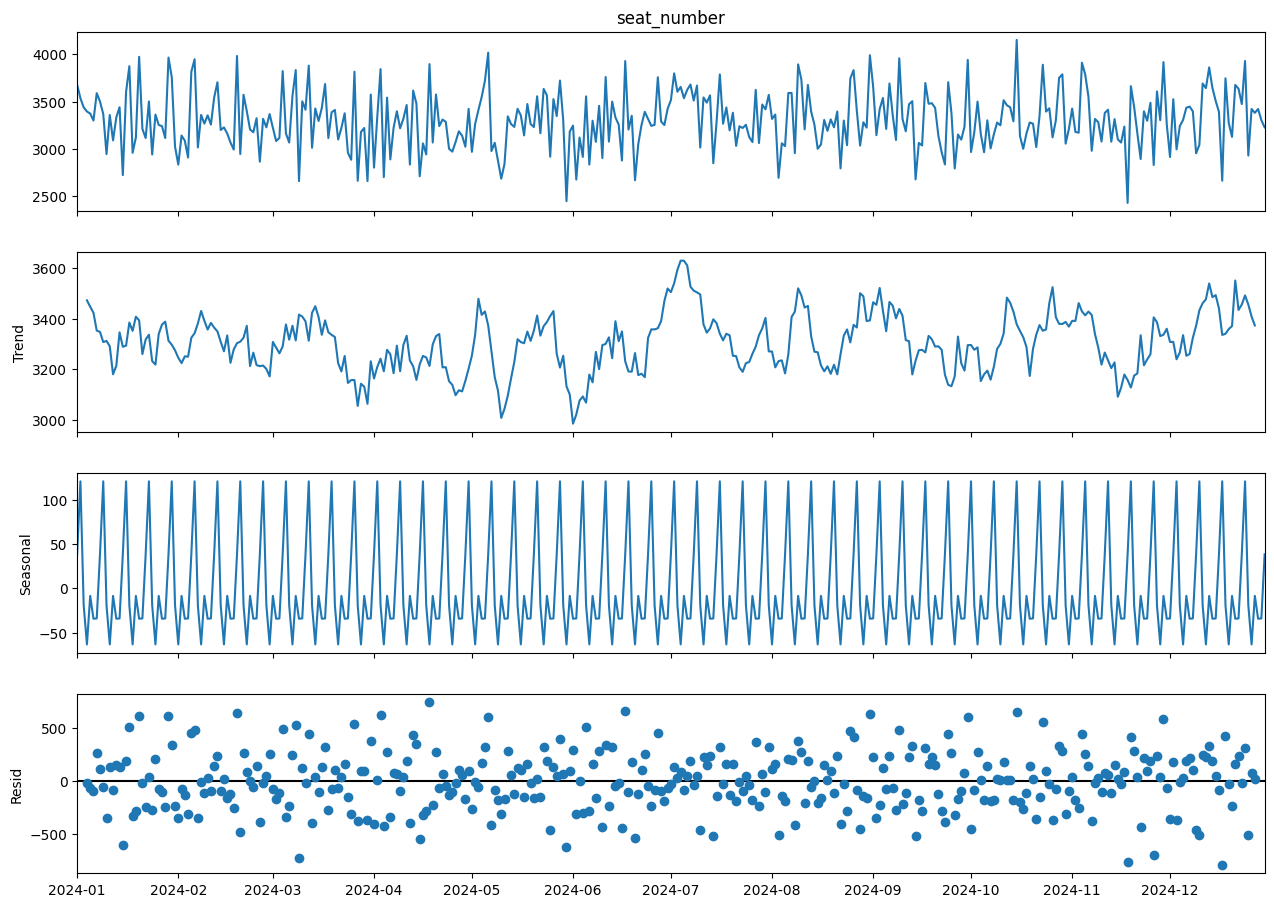

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Realizar la descomposición estacional
# Usamos period=7 porque sospechamos de una estacionalidad semanal
decomposition = seasonal_decompose(time_series_data, model='additive', period=7)

# Graficar los componentes
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

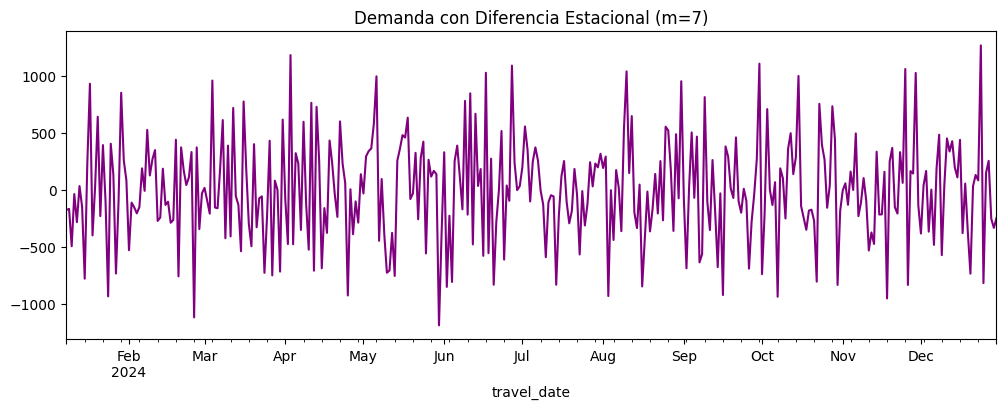

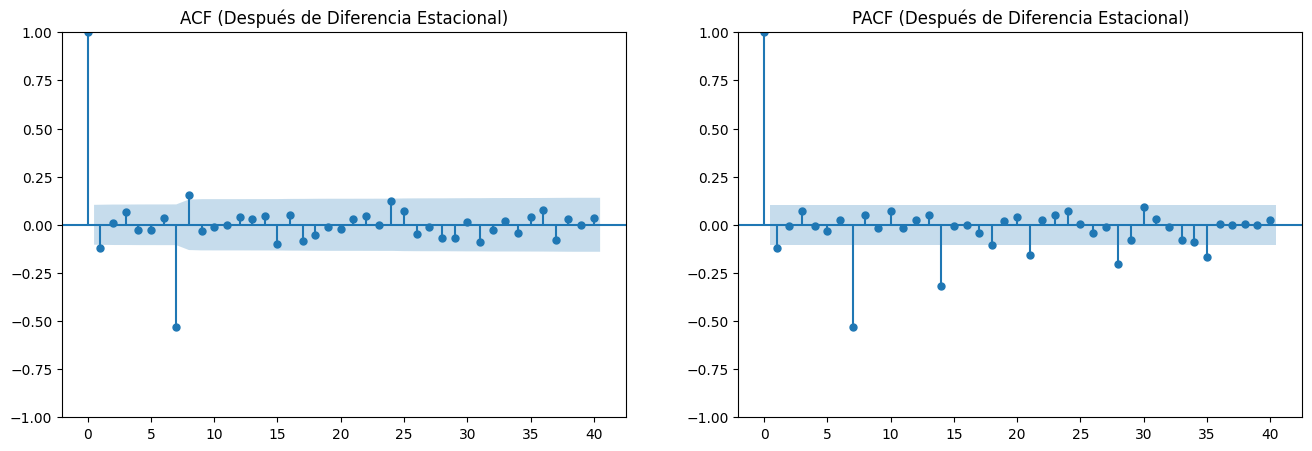

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# 1. Aplicar una diferencia estacional (periodo=7)
time_series_seasonal_diff = time_series_data.diff(7).dropna()

# 2. Graficar la serie con diferencia estacional (opcional, para ver cómo queda)
plt.figure(figsize=(12, 4))
time_series_seasonal_diff.plot(title='Demanda con Diferencia Estacional (m=7)', color='purple')
plt.show()

# 3. Graficar ACF y PACF para determinar P y Q
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(time_series_seasonal_diff, ax=axes[0], lags=40, title='ACF (Después de Diferencia Estacional)')
plot_pacf(time_series_seasonal_diff, ax=axes[1], lags=40, title='PACF (Después de Diferencia Estacional)')
plt.show()

--- Resumen del Modelo SARIMA(0,1,1)(0,1,1)7 ---
                                     SARIMAX Results                                     
Dep. Variable:                       seat_number   No. Observations:                  365
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -2563.919
Date:                           Thu, 03 Jul 2025   AIC                           5133.839
Time:                                   17:03:41   BIC                           5145.472
Sample:                               01-01-2024   HQIC                          5138.466
                                    - 12-30-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9999      1.899     -0.527      0.599      -4.722       

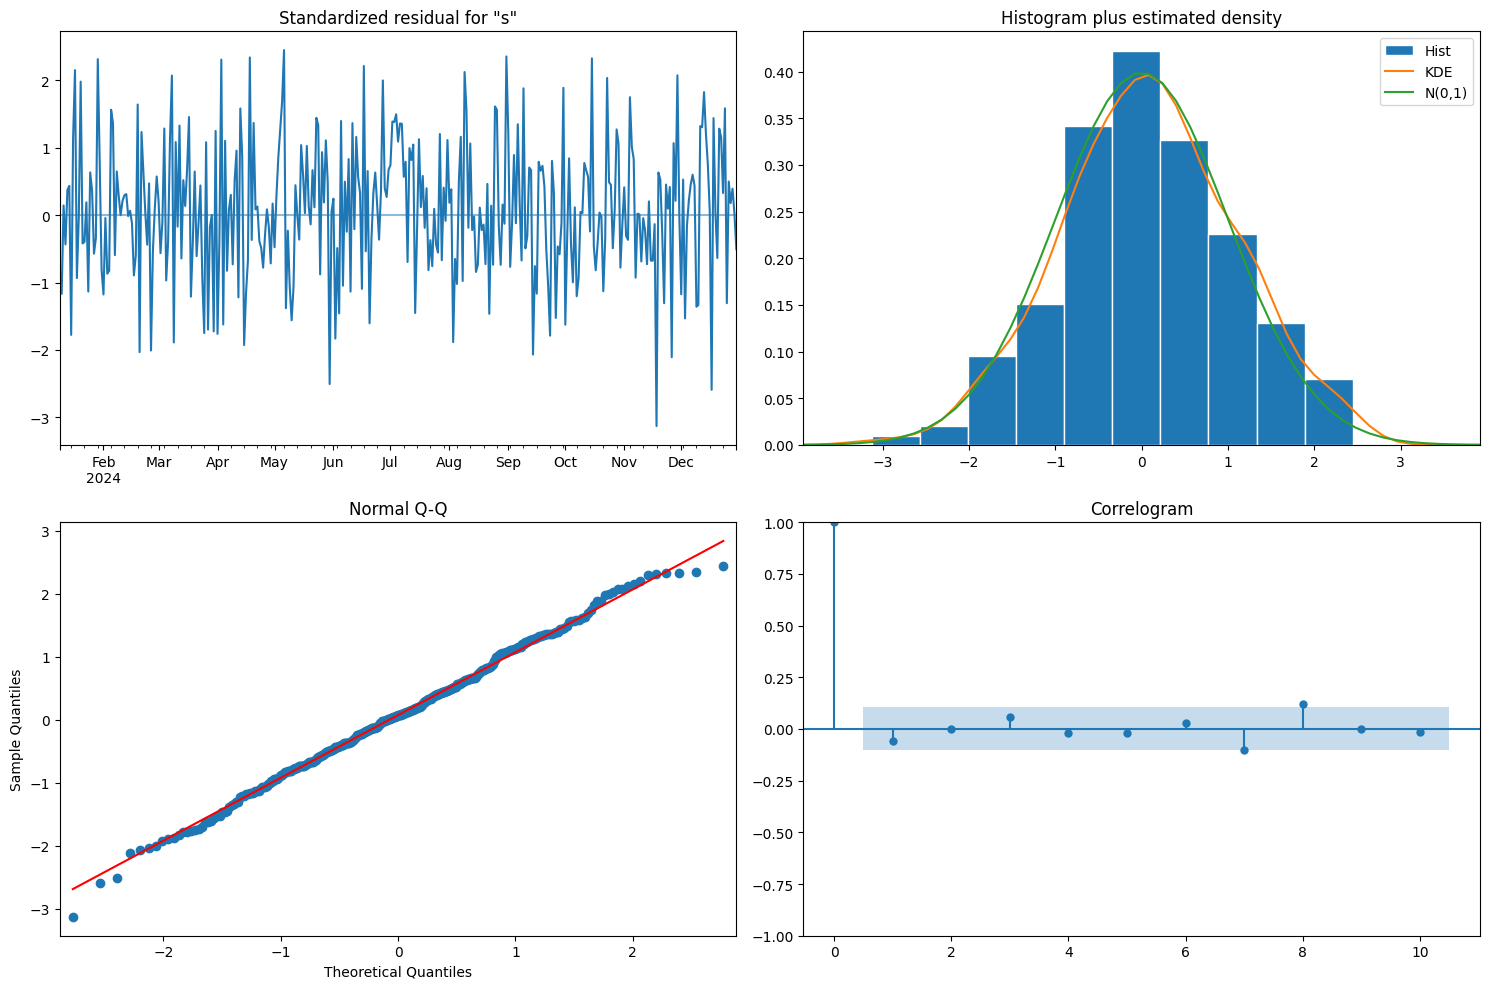

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# --- Ajustar el modelo SARIMA ---
# Orden no estacional (p,d,q) = (0,1,1)
# Orden estacional (P,D,Q)m = (0,1,1,7)

sarima_model = SARIMAX(time_series_data,
                       order=(0, 1, 1),
                       seasonal_order=(0, 1, 1, 7))

results_sarima = sarima_model.fit(disp=False)

# --- Imprimir el resumen y los diagnósticos ---
print("--- Resumen del Modelo SARIMA(0,1,1)(0,1,1)7 ---")
print(results_sarima.summary())

print("\\n" + "="*50 + "\\n")
print("--- Gráficas de Diagnóstico del Modelo SARIMA ---")
results_sarima.plot_diagnostics(figsize=(15, 10))
plt.tight_layout()
plt.show()

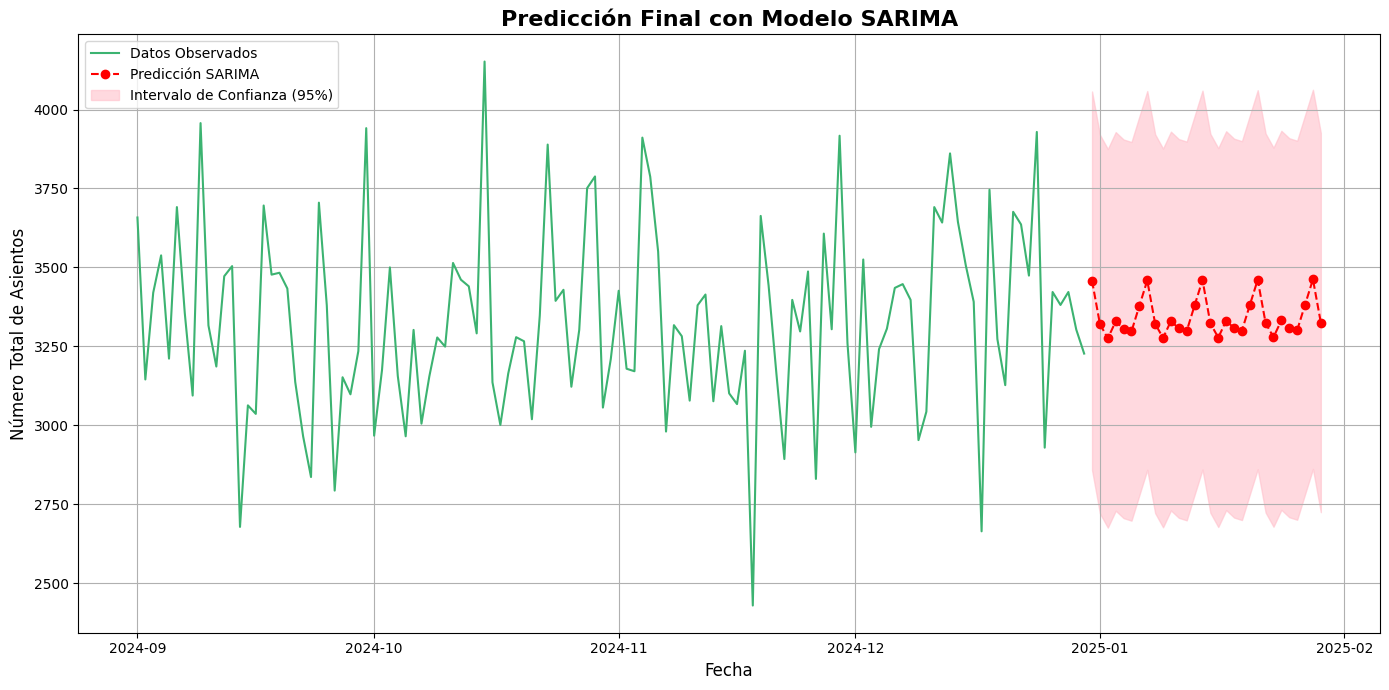

\n--- Predicción SARIMA ---
2024-12-31    3457.522337
2025-01-01    3320.410536
2025-01-02    3275.305324
2025-01-03    3328.879625
2025-01-04    3305.398248
2025-01-05    3297.422991
2025-01-06    3378.346464
2025-01-07    3458.675962
2025-01-08    3321.564162
2025-01-09    3276.458949
2025-01-10    3330.033250
2025-01-11    3306.551874
2025-01-12    3298.576617
2025-01-13    3379.500089
2025-01-14    3459.829587
2025-01-15    3322.717787
2025-01-16    3277.612575
2025-01-17    3331.186876
2025-01-18    3307.705499
2025-01-19    3299.730242
2025-01-20    3380.653715
2025-01-21    3460.983213
2025-01-22    3323.871413
2025-01-23    3278.766200
2025-01-24    3332.340501
2025-01-25    3308.859125
2025-01-26    3300.883868
2025-01-27    3381.807340
2025-01-28    3462.136838
2025-01-29    3325.025038
Freq: D, Name: predicted_mean, dtype: float64


In [17]:
import matplotlib.pyplot as plt

# --- Realizar la predicción con el modelo SARIMA ---
dias_a_predecir = 30
forecast = results_sarima.get_forecast(steps=dias_a_predecir)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()


# --- Visualizar la predicción ---
plt.figure(figsize=(14, 7))

# Graficar los datos originales (solo los últimos datos para ver mejor la predicción)
plt.plot(time_series_data['2024-09-01':], label='Datos Observados', color='mediumseagreen')

# Graficar la predicción
plt.plot(mean_forecast.index, mean_forecast.values, color='red', marker='o', linestyle='--', label='Predicción SARIMA')

# Sombrear el intervalo de confianza
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.6, label='Intervalo de Confianza (95%)')

plt.title('Predicción Final con Modelo SARIMA', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número Total de Asientos', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Imprimir los valores predichos
print("\\n--- Predicción SARIMA ---")
print(mean_forecast)

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# --- 1. Preparar las variables externas (exógenas) ---

# Crear el DataFrame para las variables exógenas usando el índice de nuestra serie
exog = pd.DataFrame(index=time_series_data.index)

# Añadir el día de la semana como una característica
exog['day_of_week'] = time_series_data.index.dayofweek

# Convertir a dummies, especificando que el tipo de dato sea int (entero)
exog = pd.get_dummies(exog['day_of_week'], prefix='dia', drop_first=True, dtype=int)


# --- 2. Ajustar el modelo SARIMAX ---
sarimax_model = SARIMAX(time_series_data,
                        exog=exog,
                        order=(0, 1, 1),
                        seasonal_order=(0, 1, 1, 7))

results_sarimax = sarimax_model.fit(disp=False)


# --- 3. Imprimir el resumen del modelo ---
print("--- Resumen del Modelo SARIMAX ---")
print(results_sarimax.summary())

--- Resumen del Modelo SARIMAX ---
                                     SARIMAX Results                                     
Dep. Variable:                       seat_number   No. Observations:                  365
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -2563.918
Date:                           Thu, 03 Jul 2025   AIC                           5145.836
Time:                                   17:09:25   BIC                           5180.736
Sample:                               01-01-2024   HQIC                          5159.717
                                    - 12-30-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dia_1          0.0062   3040.234   2.04e-06      1.000   -5958.743    5958.756
dia_2   